In [1]:
"""Use GMRES and augmented least squares to find optimal Tikhonov regularisation"""

'Use GMRES and augmented least squares to find optimal Tikhonov regularisation'

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

from deblurring.blurring import blur_and_noise
from deblurring.solvers import GMRESSolver, LSQRSolver
from common.operators import derivative_operator, identity_operator
from evaluation.tuning import StandardTuner

[INFO] 2024-11-24 22:25:36 | Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16. | numexpr.utils-_init_num_threads:148
[INFO] 2024-11-24 22:25:36 | NumExpr defaulting to 16 threads. | numexpr.utils-_init_num_threads:161


Estimated noise variance 0.00039786000623061405 vs. actual 0.0004


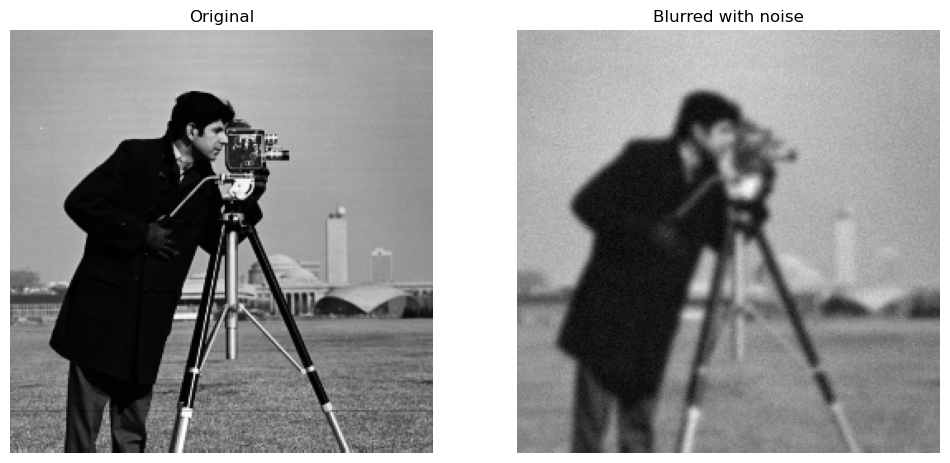

In [3]:
"""Read image and blur with added noise"""

f = plt.imread("../../data/Cameraman256.png")
f = (f - f.min()) / (f.max() - f.min())

theta = 0.02
sigma = 2.0
kernel = partial(gaussian_filter, sigma=sigma)
g = blur_and_noise(f, kernel, theta)
noise_variance = np.var(blur_and_noise(np.zeros_like(g), kernel, theta))
print(f"Estimated noise variance {noise_variance} vs. actual {np.square(theta)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(f, cmap="gray")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(g, cmap="gray")
plt.axis("off")
plt.title("Blurred with noise")
plt.show()

In [4]:
"""Set up parameters, regularisation operators and tuners"""

alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
identity = identity_operator(f)
derivative = derivative_operator(f)

gmres_tuner = StandardTuner(
    solver=GMRESSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)

lsqr_tuner = StandardTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)

[WARNING] 2024-11-24 22:25:37 | No valid reference provided | evaluation.eval_metrics-__init__:59
[WARNING] 2024-11-24 22:25:37 | No valid reference provided | evaluation.eval_metrics-__init__:59


[INFO] 2024-11-24 22:25:56 | Alpha 1e-08: discrepancy -0.00010258151563269998 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:15 | Alpha 1e-07: discrepancy -0.00010228860117923375 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:31 | Alpha 1e-06: discrepancy -0.00010002547677084612 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:38 | Alpha 1e-05: discrepancy -9.14475292945106e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:40 | Alpha 0.0001: discrepancy -7.708671992114356e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:40 | Alpha 0.001: discrepancy -5.917262373410746e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:40 | Alpha 0.01: discrepancy -9.066131978877382e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:40 | Alpha 0.1: discrepancy 0.002281992761374208 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:40 | Alpha 1.0: discrepanc

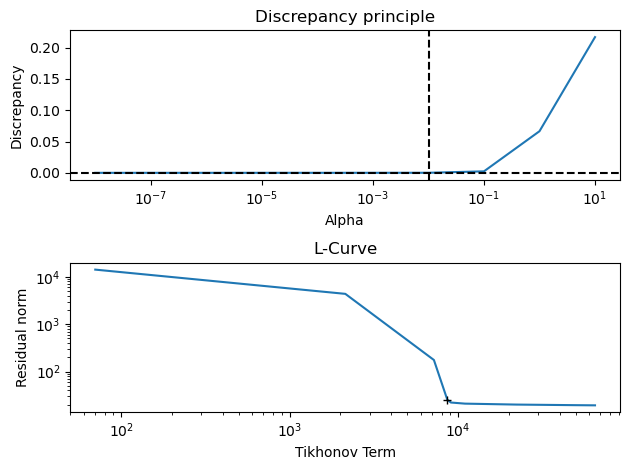

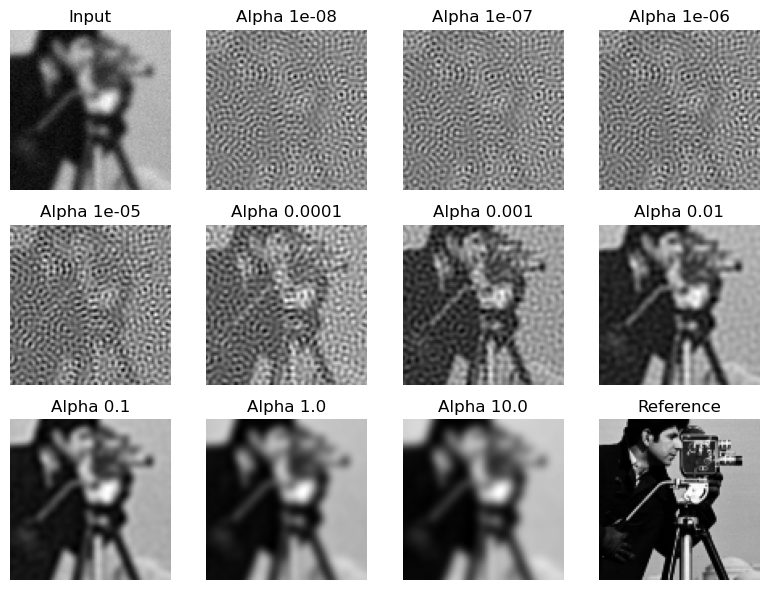

Optimal alpha: 0.010356146182215673
DP: -6.603581711221447e-06, MSE: 0.004401911974060244


In [5]:
"""Find optimal alpha using GMRES and TK0"""

gmres_tuner.parameter_sweep(
    alphas=alphas,
    L=identity,
    noise_variance=noise_variance,
    save_imgs=True
)
gmres_tuner.display_metrics()
gmres_tuner.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {gmres_tuner.optimal_alpha}")
print(f"DP: {gmres_tuner.optimal_metrics['discrepancy']}, MSE: {gmres_tuner.optimal_metrics['MSE']}")
gmres_tk0_f_hat = gmres_tuner._optimal_f_hat

[INFO] 2024-11-24 22:26:42 | Alpha 1e-08: discrepancy -7.920088307247037e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:42 | Alpha 1e-07: discrepancy -7.920087515772084e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:42 | Alpha 1e-06: discrepancy -7.920009232745712e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:43 | Alpha 1e-05: discrepancy -7.912972269683949e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:43 | Alpha 0.0001: discrepancy -7.606802539546876e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:43 | Alpha 0.001: discrepancy -5.962401502858193e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:43 | Alpha 0.01: discrepancy -9.14595908122959e-06 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:43 | Alpha 0.1: discrepancy 0.0022819904597811322 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:26:43 | Alpha 1.0: discrepancy 

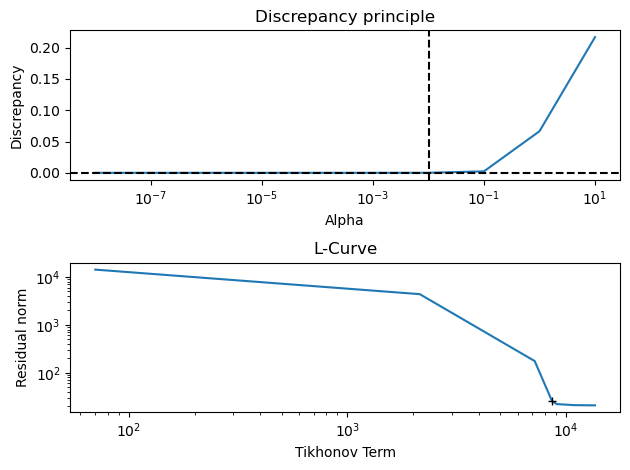

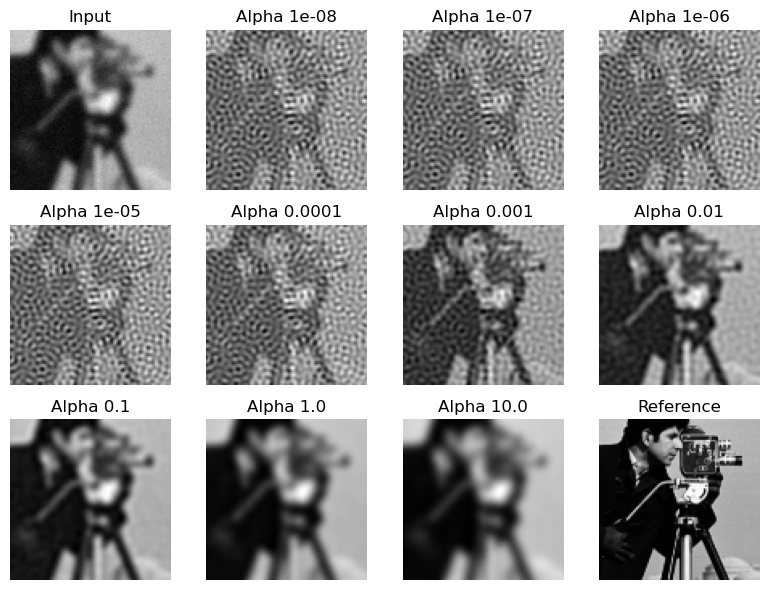

Optimal alpha: 0.010359269884819597
DP: -6.683264742406224e-06, MSE: 0.004405391794810042


In [6]:
"""Find optimal alpha using LSQR and TK0"""

lsqr_tuner.parameter_sweep(
    alphas=alphas,
    L=identity,
    noise_variance=noise_variance,
    save_imgs=True
)
lsqr_tuner.display_metrics()
lsqr_tuner.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_tuner.optimal_alpha}")
print(f"DP: {lsqr_tuner.optimal_metrics['discrepancy']}, MSE: {lsqr_tuner.optimal_metrics['MSE']}")
lsqr_tk0_f_hat = lsqr_tuner._optimal_f_hat

[INFO] 2024-11-24 22:27:06 | Alpha 1e-08: discrepancy -0.00010252236830547652 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:28 | Alpha 1e-07: discrepancy -0.00010180906868967408 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:42 | Alpha 1e-06: discrepancy -9.742979051960643e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:47 | Alpha 1e-05: discrepancy -8.657079500693117e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:48 | Alpha 0.0001: discrepancy -7.208856982561079e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:49 | Alpha 0.001: discrepancy -5.54487967738138e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:49 | Alpha 0.01: discrepancy -3.424050339512365e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:49 | Alpha 0.1: discrepancy 3.964189853074144e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:49 | Alpha 1.0: discrepanc

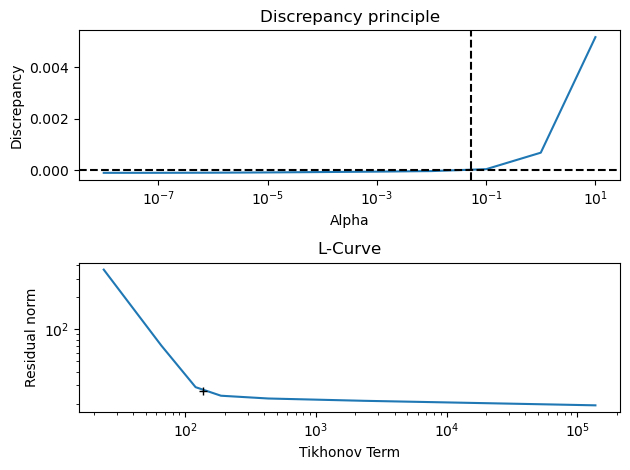

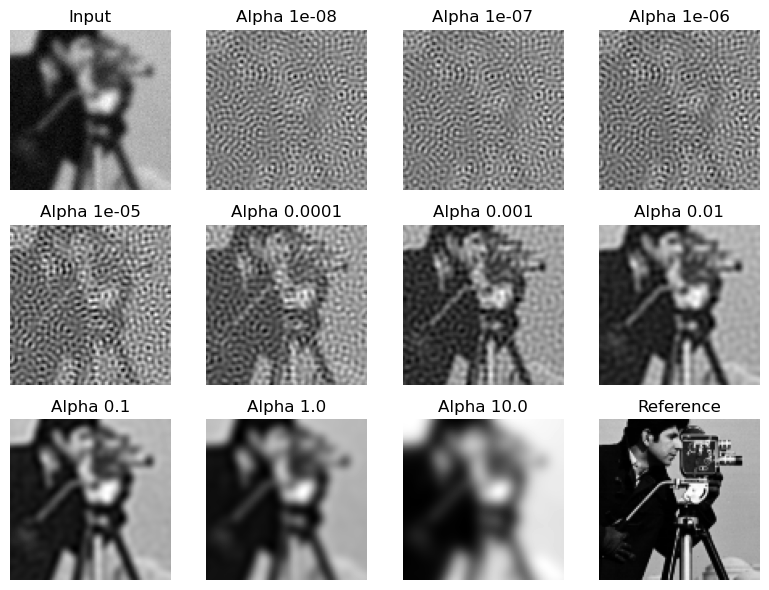

Optimal alpha: 0.051710139698128745
DP: 3.060170868128011e-06, MSE: 0.004894500543088309


In [7]:
"""Find optimal alpha using GMRES and TK1"""
gmres_tuner.parameter_sweep(
    alphas=alphas,
    L=derivative,
    noise_variance=noise_variance,
    save_imgs=True,
)
gmres_tuner.display_metrics()
gmres_tuner.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {gmres_tuner.optimal_alpha}")
print(f"DP: {gmres_tuner.optimal_metrics['discrepancy']}, MSE: {gmres_tuner.optimal_metrics['MSE']}")
gmres_tk1_f_hat = gmres_tuner._optimal_f_hat

[INFO] 2024-11-24 22:27:51 | Alpha 1e-08: discrepancy -7.920078805358346e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:51 | Alpha 1e-07: discrepancy -7.919990359946648e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:51 | Alpha 1e-06: discrepancy -7.918830708497832e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:52 | Alpha 1e-05: discrepancy -7.885967484987615e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:52 | Alpha 0.0001: discrepancy -7.248950978059135e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:52 | Alpha 0.001: discrepancy -5.5749280569135536e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:53 | Alpha 0.01: discrepancy -3.431707684482517e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:53 | Alpha 0.1: discrepancy 3.963282371434684e-05 | evaluation.eval_metrics-log_metrics:219
[INFO] 2024-11-24 22:27:53 | Alpha 1.0: discrepanc

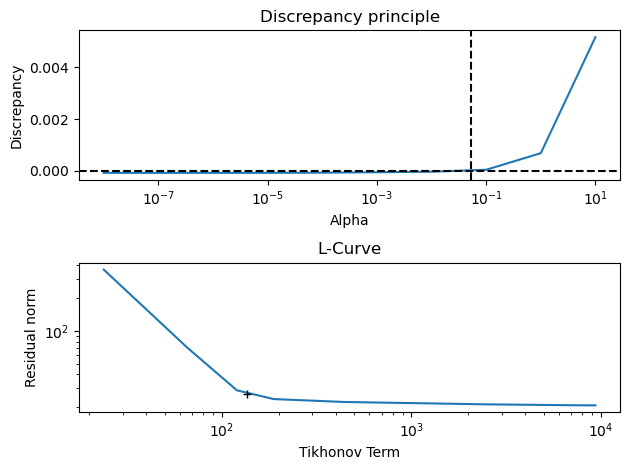

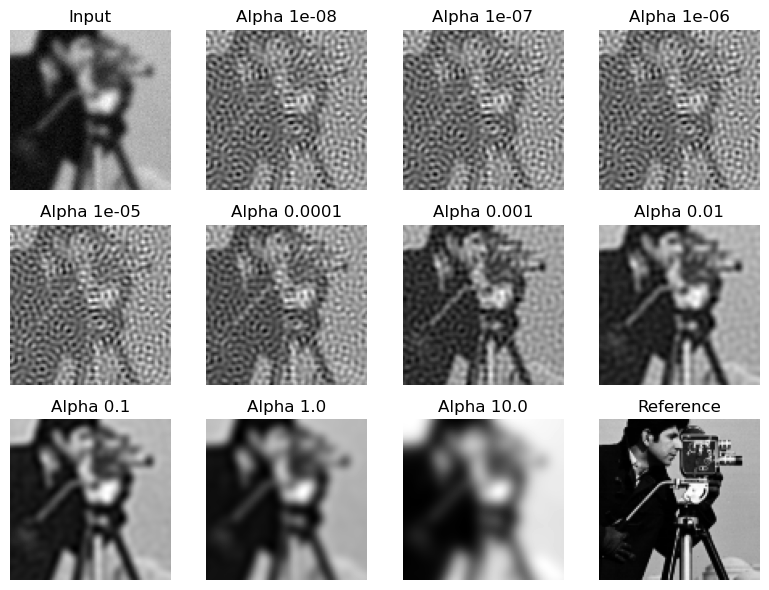

Optimal alpha: 0.051765261246875256
DP: 3.0925750613801915e-06, MSE: 0.0048944861463518455


In [8]:
"""Find optimal alpha using LSQR and TK1"""
lsqr_tuner.parameter_sweep(
    alphas=alphas,
    L=derivative,
    noise_variance=noise_variance,
    save_imgs=True,
)
lsqr_tuner.display_metrics()
lsqr_tuner.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_tuner.optimal_alpha}")
print(f"DP: {lsqr_tuner.optimal_metrics['discrepancy']}, MSE: {lsqr_tuner.optimal_metrics['MSE']}")
lsqr_tk1_f_hat = lsqr_tuner._optimal_f_hat

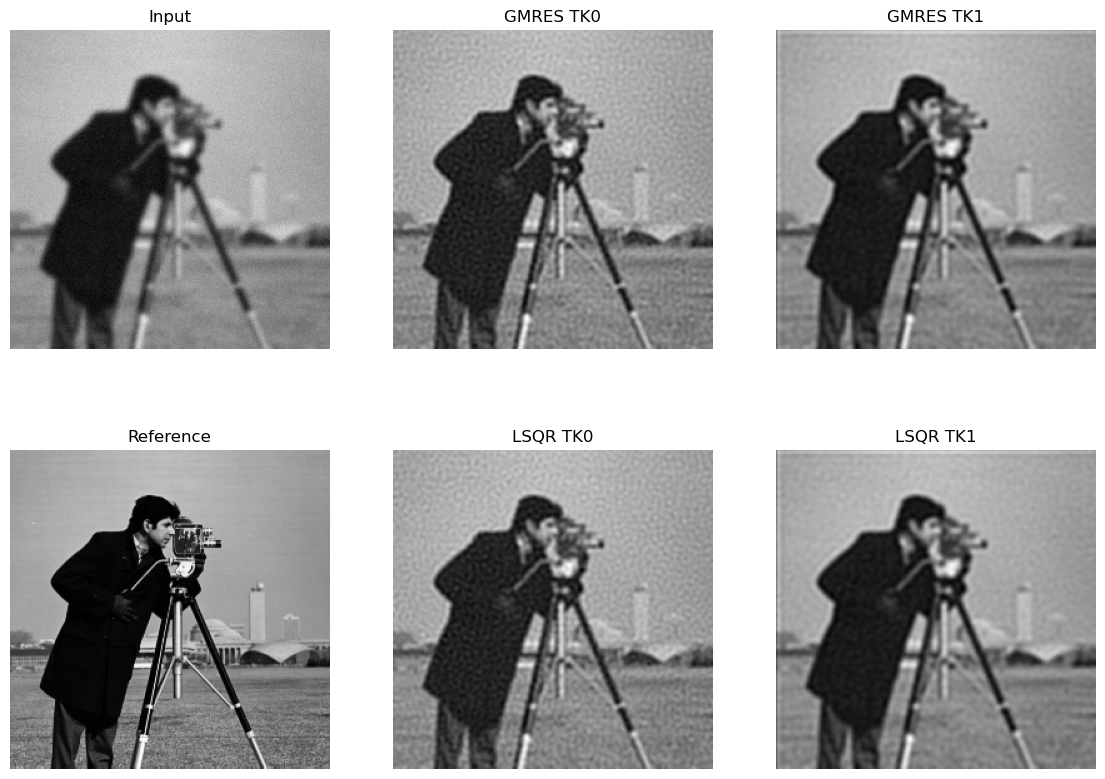

In [9]:
"""Compare different techniques"""

_, axs = plt.subplots(2, 3, figsize=(14, 10))
axs[0, 0].imshow(g, cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[0, 1].imshow(gmres_tk0_f_hat, cmap="gray")
axs[0, 1].set_title("GMRES TK0")
axs[0, 1].axis("off")
axs[0, 2].imshow(gmres_tk1_f_hat, cmap="gray")
axs[0, 2].set_title("GMRES TK1")
axs[0, 2].axis("off")
axs[1, 0].imshow(f, cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[1, 1].imshow(lsqr_tk0_f_hat, cmap="gray")
axs[1, 1].set_title("LSQR TK0")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_tk1_f_hat, cmap="gray")
axs[1, 2].set_title("LSQR TK1")
axs[1, 2].axis("off")
plt.show()